# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [3]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## ⚙️ Step 2: Environment Setup

In [53]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "Pendulum-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

seed = 42                  # Random seed to ensure experiment reproducibility

total_timesteps = 300_000   # Number of training steps for Expert PPO (Recommended: 40k for CartPole, 300k for Pendulum)

num_prefs = 10_000            # Number of preference samples
sample_prefs = 8_000

# ===========================================================


set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
sample_length = 500
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'}")


✅ Environment: Pendulum-v1 | Action space: Continuous


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [5]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{seed}.zip")
env.close()


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.19e+03 |
| time/              |           |
|    fps             | 7353      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -1.14e+03    |
| time/                   |              |
|    fps                  | 3558         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036137116 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41      

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [54]:
def evaluate_policy(model, env, episodes=10):
    scores = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
pi2_model.save(f"{env_id}_pi2_model_seed{seed}.zip")
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_240000_steps.zip with ~-299.4 reward


## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [26]:
import numpy as np
import pickle
from tqdm import trange
import numpy as np

def generate_trajectory(model, env, seed, max_steps):
    obs_list, act_list, rewards, mask = [], [], [], []
    obs, _ = env.reset(seed=seed)

    for step in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(np.array(obs))       # ensure obs is np.array
        act_list.append(np.array(action))    # ensure action is np.array
        rewards.append(reward)
        mask.append(1)

        obs = obs_
        if done:
            break

    pad_len = max_steps - len(obs_list)
    if pad_len > 0:
        obs_shape = obs_list[0].shape
        obs_list += [np.zeros(obs_shape)] * pad_len
        act_shape = act_list[0].shape if isinstance(act_list[0], np.ndarray) else ()
        act_list += [np.zeros(act_shape)] * pad_len
        rewards += [0.0] * pad_len
        mask += [0] * pad_len

    return {
        "obs": np.stack(obs_list),       # [T, obs_dim]
        "acts": np.stack(act_list),      # [T] (discrete) or [T, act_dim] (continuous)
        "rews": np.array(rewards),       # [T]
        "mask": np.array(mask)           # [T]
    }

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
env = gym.make(env_id)
for idx in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(model = expert_model, env=env, seed=idx, max_steps=sample_length)
    traj2 = generate_trajectory(pi2_model, env=env, seed=idx, max_steps=sample_length)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}_{sample_length}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")


🔄 Generating preference pairs: 100%|██████████| 10000/10000 [08:27<00:00, 19.70it/s]


✅ Saved 10000 preference pairs to prefs_Pendulum-v1_seed42_700.pkl


In [27]:
class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, prefs, is_discrete):
        self.prefs = prefs
        self.is_discrete = is_discrete

    def __len__(self):
        return len(self.prefs)

    def __getitem__(self, idx):
        traj1, traj2, label = self.prefs[idx]

        return {
            "obs1": torch.from_numpy(traj1["obs"]).float(),
            "acts1": torch.from_numpy(traj1["acts"]).long() if self.is_discrete else torch.from_numpy(traj1["acts"]).float(),
            "mask1": torch.from_numpy(traj1["mask"]).float(),

            "obs2": torch.from_numpy(traj2["obs"]).float(),
            "acts2": torch.from_numpy(traj2["acts"]).long() if self.is_discrete else torch.from_numpy(traj2["acts"]).float(),
            "mask2": torch.from_numpy(traj2["mask"]).float(),

            "label": torch.tensor(label, dtype=torch.float32)
        }

## ⚙️ Step 7: Train DPO Policy

In [35]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo(dataloader, env, seed=0, epochs=25, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    
    model = PPO("MlpPolicy", env, verbose=0, seed=seed, device=device)
    policy = model.policy
    policy.train()  # ensure in training mode
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]

            obs1_flat = obs1.view(-1, obs_dim)
            obs2_flat = obs2.view(-1, obs_dim)
            acts1_flat = acts1.view(-1) if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1) if is_discrete else acts2.view(-1, act_dim)

            dist1 = policy.get_distribution(obs1_flat)  # returns Categorical
            dist2 = policy.get_distribution(obs2_flat)
            lp1 = dist1.log_prob(acts1_flat).view(B, T)  # [B, T]
            lp2 = dist2.log_prob(acts2_flat).view(B, T)
            
            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits = logp1_sum - logp2_sum        # [B]

            loss = F.binary_cross_entropy_with_logits(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:sample_prefs]

dataset = PreferenceDataset(prefs, is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

dpo_model = train_dpo(loader, env)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'prefs_Pendulum-v1_seed42.pkl'

In [36]:
import torch
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO

def train_dpo_from_ref(dataloader, ref_policy_sb3, env, beta=0.05, seed=42, epochs=25, device='cpu'):
    torch.manual_seed(seed)

    # Determine if environment is discrete or continuous
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # Get frozen reference policy from SB3 PPO model
    ref_policy = ref_policy_sb3.policy
    ref_policy.eval().to(device)

    # Create trainable copy of the reference policy
    policy = copy.deepcopy(ref_policy)
    policy.train().to(device)

    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0

        for batch in dataloader:
            # Move batch to device
            obs1 = batch["obs1"].to(device)     # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)   # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)   # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)  # [B]

            B, T = obs1.shape[:2]

            # Flatten time dimension for easier batch processing
            obs1_flat = obs1.view(-1, obs_dim)
            obs2_flat = obs2.view(-1, obs_dim)
            acts1_flat = acts1.view(-1) if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1) if is_discrete else acts2.view(-1, act_dim)

            # --- Compute log-probs from trainable policy ---
            dist1 = policy.get_distribution(obs1_flat)
            dist2 = policy.get_distribution(obs2_flat)
            logp1 = dist1.log_prob(acts1_flat)
            logp2 = dist2.log_prob(acts2_flat)

            with torch.no_grad():
                dist1_ref = ref_policy.get_distribution(obs1_flat)
                dist2_ref = ref_policy.get_distribution(obs2_flat)
                logp1_ref = dist1_ref.log_prob(acts1_flat)
                logp2_ref = dist2_ref.log_prob(acts2_flat)

            if not is_discrete:
                # Ensure log-probs are at least 1D
                if logp1.dim() > 1:
                    logp1 = logp1.sum(-1)
                    logp2 = logp2.sum(-1)
                    logp1_ref = logp1_ref.sum(-1)
                    logp2_ref = logp2_ref.sum(-1)

            lp1 = (logp1 - logp1_ref).view(B, -1)
            lp2 = (logp2 - logp2_ref).view(B, -1)

            # Mask padded tokens
            logp1_sum = (lp1 * mask1).sum(dim=1)
            logp2_sum = (lp2 * mask2).sum(dim=1)

            # Compute logits for DPO loss
            logits = beta * (logp1_sum - logp2_sum)  # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)

            # Backprop and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy


Training DPO (π₂ → Expert) with β = 0.25
Epoch 1/25, Loss: 0.5660
Epoch 2/25, Loss: 0.5300
Epoch 3/25, Loss: 0.5066
Epoch 4/25, Loss: 0.4580
Epoch 5/25, Loss: 0.4462
Epoch 6/25, Loss: 0.4535
Epoch 7/25, Loss: 0.4872
Epoch 8/25, Loss: 0.4360
Epoch 9/25, Loss: 0.4646
Epoch 10/25, Loss: 0.4336
Epoch 11/25, Loss: 0.4555
Epoch 12/25, Loss: 0.4652
Epoch 13/25, Loss: 0.4487
Epoch 14/25, Loss: 0.4660
Epoch 15/25, Loss: 0.4280
Epoch 16/25, Loss: 0.4205
Epoch 17/25, Loss: 0.4320
Epoch 18/25, Loss: 0.4365
Epoch 19/25, Loss: 0.4368
Epoch 20/25, Loss: 0.4310
Epoch 21/25, Loss: 0.4412
Epoch 22/25, Loss: 0.4397
Epoch 23/25, Loss: 0.4193
Epoch 24/25, Loss: 0.4305
Epoch 25/25, Loss: 0.4445
Final avg reward for β = 0.25: -243.71
Training DPO (π₂ → Expert) with β = 0.5
Epoch 1/25, Loss: 0.8310
Epoch 2/25, Loss: 0.7672
Epoch 3/25, Loss: 0.7540
Epoch 4/25, Loss: 0.6400
Epoch 5/25, Loss: 0.6549
Epoch 6/25, Loss: 0.6470
Epoch 7/25, Loss: 0.6749
Epoch 8/25, Loss: 0.6155
Epoch 9/25, Loss: 0.6432
Epoch 10/25, L

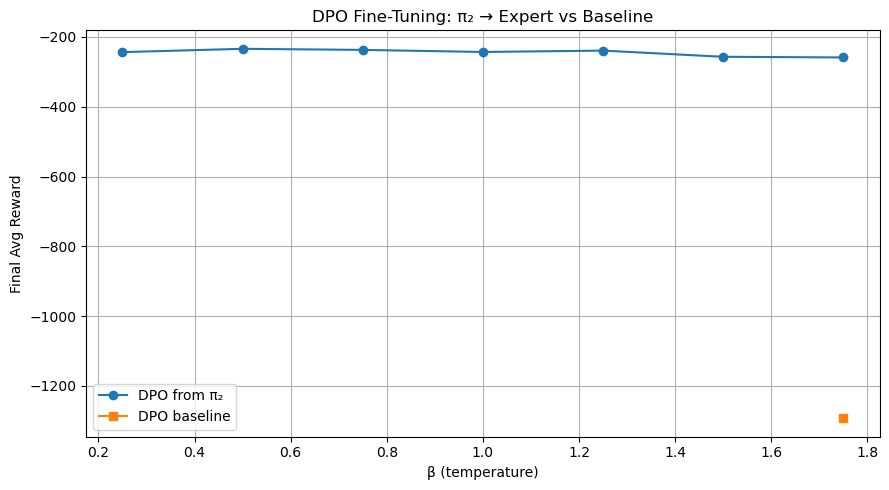

--------------------------------we use beta = 0.5


In [28]:
def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns



import matplotlib.pyplot as plt
import numpy as np

def fine_tune_dpo_with_betas(env, dataloader, pi2_model, beta_values_from_ref, beta_values, epochs=25, device='cpu'):
    rewards_from_ref = {}
    rewards = {}

    obs_dim = env.observation_space.shape[0]
    is_discrete = hasattr(env.action_space, "n")
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # ✅ Train DPO starting from π₂ and moving toward expert
    for beta in beta_values_from_ref:
        print(f"Training DPO (π₂ → Expert) with β = {beta}")

        trained_policy_from_ref = train_dpo_from_ref(
            dataloader=dataloader,
            ref_policy_sb3=pi2_model,
            env=env,
            beta=beta,
            epochs=epochs,
            device=device
        )

        avg_reward = np.mean(eval_policy(trained_policy_from_ref, env, episodes=10))
        print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
        rewards_from_ref[beta] = avg_reward


    trained_policy = train_dpo(
            dataloader=dataloader,
            env=env,
            epochs=epochs,
            device=device
    )

    avg_reward = np.mean(eval_policy(trained_policy, env, episodes=10))
    print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
    rewards[beta] = avg_reward




    # ✅ Plot both curves
    plt.figure(figsize=(9, 5))
    plt.plot(list(rewards_from_ref.keys()), list(rewards_from_ref.values()), marker='o', label="DPO from π₂")
    plt.plot(list(rewards.keys()), list(rewards.values()), marker='s', label="DPO baseline")
    plt.xlabel("β (temperature)")
    plt.ylabel("Final Avg Reward")
    plt.title("DPO Fine-Tuning: π₂ → Expert vs Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rewards_from_ref, rewards




with open(f"prefs_{env_id}_seed{seed}_500.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:sample_prefs]

dataset = PreferenceDataset(prefs, is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

beta_values_from_ref =np.arange(0.25,2,0.25)
beta_values = np.arange(1, 2, 1)
# we could also potentially choose an adaptive beta, like : beta = beta_init * (epoch / max_epochs)


'''
When I increase β, I am being more conservative and penalizing drift from pi_ref.
When I decrease β, I allow the model to explore more and drift away from pi_ref.

Becasue pi2 is close to expert, B do not play a key role here

'''


rewards_from_ref, rewards = fine_tune_dpo_with_betas(env, loader, pi2_model,beta_values_from_ref,beta_values=beta_values)
beta_from_ref = max(rewards_from_ref, key = rewards_from_ref.get)
#beta_from_ref = 0.5
print(f"--------------------------------we use beta = {beta_from_ref}")

In [37]:
dpo_model_from_ref = train_dpo_from_ref(loader,pi2_model, env, beta=beta_from_ref, seed=seed)
torch.save(dpo_model_from_ref.state_dict(), f"{env_id}_dpo_pi2_seed{seed}.pth")

dpo_model = train_dpo(loader, env, seed=seed)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

Epoch 1/25, Loss: 0.8310
Epoch 2/25, Loss: 0.7672
Epoch 3/25, Loss: 0.7540
Epoch 4/25, Loss: 0.6400
Epoch 5/25, Loss: 0.6549
Epoch 6/25, Loss: 0.6470
Epoch 7/25, Loss: 0.6749
Epoch 8/25, Loss: 0.6155
Epoch 9/25, Loss: 0.6432
Epoch 10/25, Loss: 0.5683
Epoch 11/25, Loss: 0.6567
Epoch 12/25, Loss: 0.5951
Epoch 13/25, Loss: 0.5477
Epoch 14/25, Loss: 0.6151
Epoch 15/25, Loss: 0.5617
Epoch 16/25, Loss: 0.5345
Epoch 17/25, Loss: 0.6019
Epoch 18/25, Loss: 0.5816
Epoch 19/25, Loss: 0.6063
Epoch 20/25, Loss: 0.6142
Epoch 21/25, Loss: 0.5727
Epoch 22/25, Loss: 0.5924
Epoch 23/25, Loss: 0.5819
Epoch 24/25, Loss: 0.5920
Epoch 25/25, Loss: 0.5413
Epoch 1/25, Loss: 1.3641
Epoch 2/25, Loss: 0.8024
Epoch 3/25, Loss: 0.5829
Epoch 4/25, Loss: 0.4777
Epoch 5/25, Loss: 0.4254
Epoch 6/25, Loss: 0.3987
Epoch 7/25, Loss: 0.3854
Epoch 8/25, Loss: 0.3775
Epoch 9/25, Loss: 0.3724
Epoch 10/25, Loss: 0.3694
Epoch 11/25, Loss: 0.3650
Epoch 12/25, Loss: 0.3629
Epoch 13/25, Loss: 0.3576
Epoch 14/25, Loss: 0.3543
Epoc

## 🧠 Step 8: Train RewardNet from Preferences (for PPO-RLHF)

In [12]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.is_discrete = is_discrete
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, states, actions):
        if self.is_discrete:
            one_hot = F.one_hot(actions.view(-1), num_classes=self.act_dim).float()
            x = torch.cat([states, one_hot], dim=-1)
        else:
            x = torch.cat([states, actions], dim=-1)
        return self.net(x).squeeze(-1)

def train_reward_model(dataloader, obs_dim, act_dim, is_discrete, epochs=50, lr=1e-3, device='cpu'):
    model = RewardNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            r1 = model(obs1.view(-1, obs_dim), acts1.view(-1) if is_discrete else acts1.view(-1, act_dim))
            r2 = model(obs2.view(-1, obs_dim), acts2.view(-1) if is_discrete else acts2.view(-1, act_dim))

            r1 = r1.view(obs1.shape[0], obs1.shape[1]) * mask1
            r2 = r2.view(obs2.shape[0], obs2.shape[1]) * mask2

            r1_sum = r1.sum(dim=1)  # [B]
            r2_sum = r2.sum(dim=1)  # [B]

            logits = r1_sum - r2_sum  # [B]
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:sample_prefs]

dataset = PreferenceDataset(prefs, is_discrete=is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

reward_model = train_reward_model(loader, obs_dim, act_dim, is_discrete)
torch.save(reward_model.state_dict(), f"{env_id}_reward_model_seed{seed}.pth")


Epoch 1/50, Loss: 0.0840
Epoch 2/50, Loss: 0.0176
Epoch 3/50, Loss: 0.0260
Epoch 4/50, Loss: 0.0331
Epoch 5/50, Loss: 0.0239
Epoch 6/50, Loss: 0.0255
Epoch 7/50, Loss: 0.0110
Epoch 8/50, Loss: 0.0178
Epoch 9/50, Loss: 0.0169
Epoch 10/50, Loss: 0.0115
Epoch 11/50, Loss: 0.0019
Epoch 12/50, Loss: 0.0051
Epoch 13/50, Loss: 0.0313
Epoch 14/50, Loss: 0.0235
Epoch 15/50, Loss: 0.0089
Epoch 16/50, Loss: 0.0303
Epoch 17/50, Loss: 0.0150
Epoch 18/50, Loss: 0.0107
Epoch 19/50, Loss: 0.0124
Epoch 20/50, Loss: 0.0110
Epoch 21/50, Loss: 0.0272
Epoch 22/50, Loss: 0.0133
Epoch 23/50, Loss: 0.0003
Epoch 24/50, Loss: 0.0106
Epoch 25/50, Loss: 0.0127
Epoch 26/50, Loss: 0.0068
Epoch 27/50, Loss: 0.0076
Epoch 28/50, Loss: 0.0001
Epoch 29/50, Loss: 0.0012
Epoch 30/50, Loss: 0.0143
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0161
Epoch 33/50, Loss: 0.0024
Epoch 34/50, Loss: 0.0077
Epoch 35/50, Loss: 0.0067
Epoch 36/50, Loss: 0.0052
Epoch 37/50, Loss: 0.0146
Epoch 38/50, Loss: 0.0000
Epoch 39/50, Loss: 0.

## 🔁 Step 9: Train PPO-RLHF (Reward Finetuned from Expert π₁)

In [13]:
import gymnasium as gym
from gymnasium import Wrapper

class RewardNetWrapper(Wrapper):
    def __init__(self, env, reward_net, is_discrete):
        super().__init__(env)
        self.reward_net = reward_net
        self.is_discrete = is_discrete

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Convert to tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            act_tensor = torch.tensor(action, dtype=torch.long).unsqueeze(0)
        else:
            act_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # Predict learned reward
        with torch.no_grad():
            reward = self.reward_net(obs_tensor, act_tensor).item()

        return obs, reward, terminated, truncated, info

# Wrap the environment with the trained reward_net
reward_model.eval()  # Ensure the model is in inference mode
env = RewardNetWrapper(gym.make(env_id), reward_model, is_discrete)
env = Monitor(env)

# Retrain the policy using the new reward
rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
rlhf_model.learn(total_timesteps=total_timesteps)
rlhf_model.save(f"{env_id}_rlhf_seed{seed}.zip")


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -179     |
| time/              |          |
|    fps             | 1759     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -179         |
| time/                   |              |
|    fps                  | 1344         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0033787978 |
|    clip_fraction        | 0.0181       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    

## 📊 Step 10: Compare PPO Expert vs PPO-RLHF vs DPO

<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\p'
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_47532/3957302756.py:36: SyntaxWarning: invalid escape sequence '\p'
  labels=["Expert ($\pi_1$)", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"],
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_47532/3957302756.py:36:

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[-126.12483077338585, -0.7985128329288523, -123.37627999498793, -371.8371892615491, -1490.9736161166782, -247.92249266068998, -0.6986963756028266, -124.19590277444952, -128.34040498872145, -281.49885278954645, -528.0774723337355, -256.1107857533537, -130.737419448848, -252.44693326371484, -261.0046677084174, -121.97087338080242, -2.6704357245038315, -270.4053352335613, -127.87237630751014, -2.2165347169878538, -124.70550270442418, -250.14572443148506, -124.13370543610067, -122.95840521746098, -124.78235931847941, -243.72175563624666, -0.44455982995140847, -125.98689509718078, -249.030170513023, -386.4883191015042, -125.58584574812586, -321.013813899197, -257.41234518065085, -1.4710218281593421, -436.58794919986565, -124.81322128802819, -253.19503417708594, -1

/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_47532/3957302756.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([returns_expert, returns_rlhf, returns_dpo, returns_pi2, returns_dpo_from_pi2],
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_47532/3957302756.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([returns_expert, returns_pi2, returns_dpo_from_pi2],


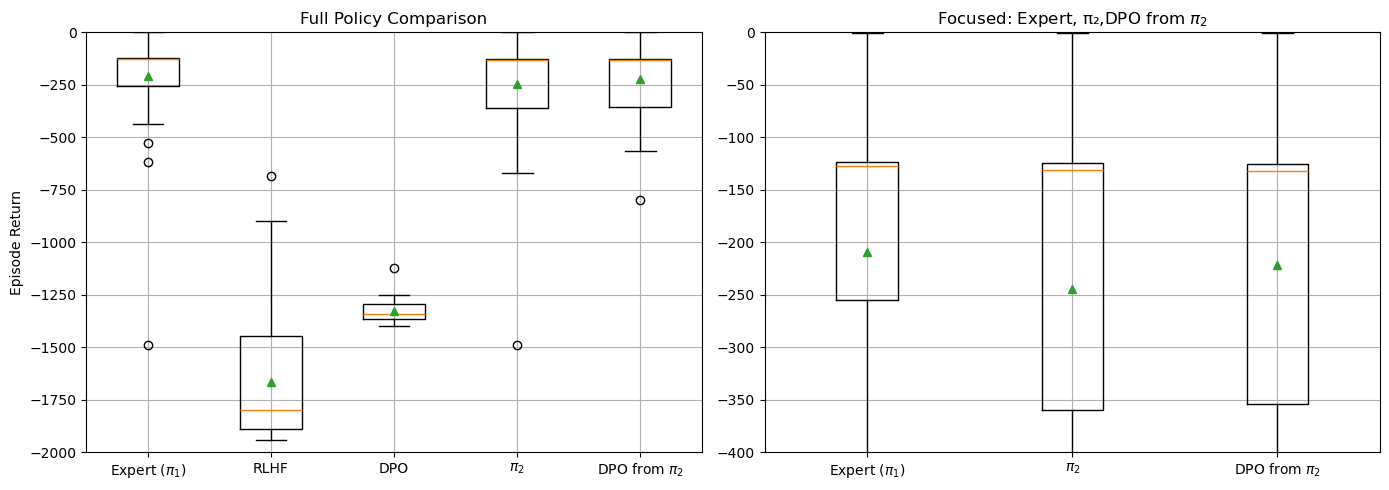

In [68]:
def eval_policy(model, env, episodes=50):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0]
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns


env = gym.make(env_id)
returns_expert = eval_policy(PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env), env)
returns_rlhf   = eval_policy(PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env), env)
dpo_model = PPO("MlpPolicy", env, verbose=0, seed=seed)
state_dict = torch.load(f"{env_id}_dpo_seed{seed}.pth")
dpo_model.policy.load_state_dict(state_dict)
returns_dpo    = eval_policy(dpo_model, env)
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{seed}.zip", env=env)
returns_pi2 = eval_policy(pi2_model, env)
dpo_model_from_pi2 = PPO("MlpPolicy", env, verbose=0, seed=seed)
dpo_model_from_pi2.policy.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))
returns_dpo_from_pi2 = eval_policy(dpo_model_from_pi2, env)
print(returns_expert)
print(returns_pi2)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Full comparison
axes[0].boxplot([returns_expert, returns_rlhf, returns_dpo, returns_pi2, returns_dpo_from_pi2],
                labels=["Expert ($\pi_1$)", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"],
                showmeans=True)
axes[0].set_title("Full Policy Comparison")
axes[0].set_ylabel("Episode Return")
axes[0].set_ylim([-2000, 0])
axes[0].grid(True)

# Second subplot: Only DPO, π₁, and π₂
axes[1].boxplot([returns_expert, returns_pi2, returns_dpo_from_pi2],
                labels=["Expert ($\pi_1$)", "$\pi_2$", "DPO from $\pi_2$"],
                showmeans=True)
axes[1].set_title("Focused: Expert, π₂,DPO from $\pi_2$")
axes[1].set_ylim([-400, 0])
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{env_id}_dual_benchmark_{seed}_dataset{sample_prefs}.png", dpi=300)
plt.show()




<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_47532/4259130483.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"]
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_47532/4259130483.py:66: SyntaxWarning: invalid escape sequence '\p'
  titles = ["Expert", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"]


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


✅ GIF saved to: /Users/mathis/Master/RL/project/EE-568-RL/Pendulum-v1_comparison_seed42_dataset8000.gif


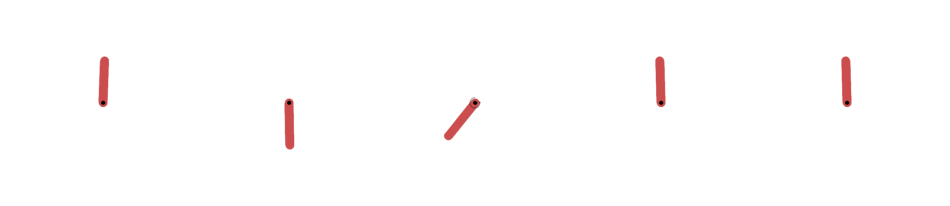

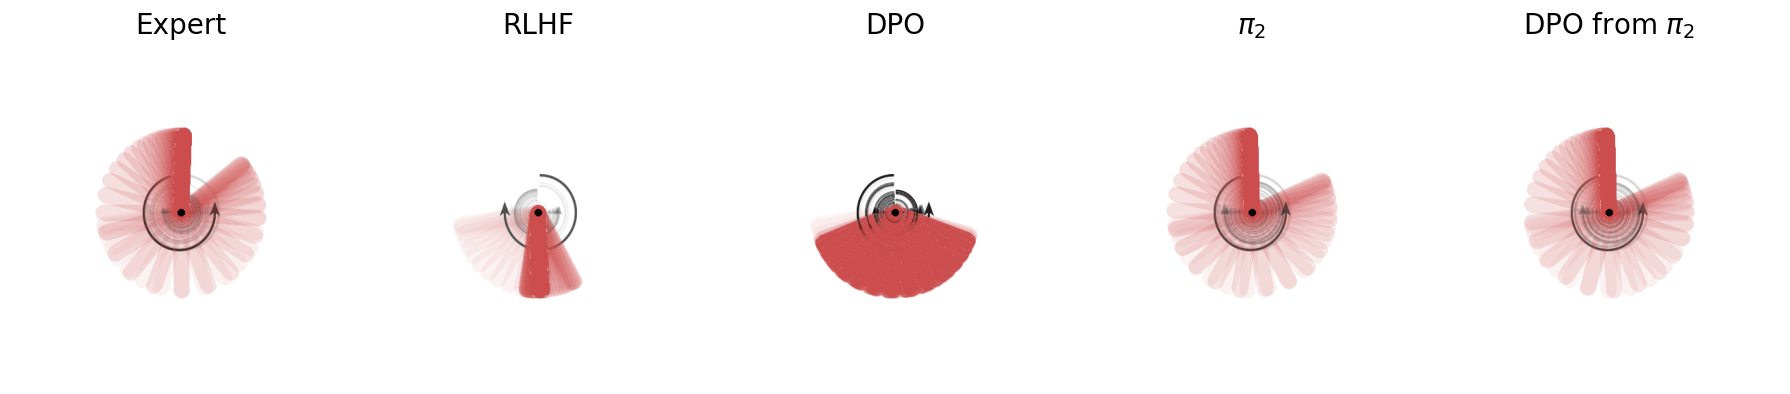

In [45]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from stable_baselines3 import PPO
import os

# Step 1: Run a single episode and record rendered frames
def record_episode(model, env, seed, max_steps=1000):
    frames = []
    obs, _ = env.reset(seed=seed)
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = model.predict(obs, deterministic=True)[0]
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

# Step 2: Combine multiple frame sequences into a single animation and optionally save as a GIF
def show_combined_animation(frames_list, fps=30, gif_path=None):
    min_len = min(len(f) for f in frames_list)
    fig = plt.figure(figsize=(12, 4))
    plt.axis('off')
    init_frame = np.hstack([f[0] for f in frames_list])
    im = plt.imshow(init_frame)

    def update(i):
        combined = np.hstack([f[i] for f in frames_list])
        im.set_array(combined)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=min_len, interval=1000/fps)

    if gif_path:
        ani.save(gif_path, writer='pillow', fps=fps)
        print(f"✅ GIF saved to: {os.path.abspath(gif_path)}")

    return HTML(ani.to_jshtml())

def trajectory_overlay_faded(frames, threshold=30, min_alpha=0.05, max_alpha=0.6):
    frames = [f.astype(np.float32) for f in frames]
    H, W, C = frames[0].shape

    overlay = np.ones((H, W, C), dtype=np.float32) * 255
    num_frames = len(frames)

    for idx, frame in enumerate(frames):
        diff = np.abs(frame - 255)
        mask = (diff.mean(axis=2) > threshold)

        alpha = min_alpha + (max_alpha - min_alpha) * (idx / (num_frames - 1))

        for c in range(3):
            overlay[:, :, c][mask] = (
                alpha * frame[:, :, c][mask] +
                (1 - alpha) * overlay[:, :, c][mask]
            )
    return np.clip(overlay, 0, 255).astype(np.uint8)

def show_trajectory_comparison(img_expert, img_rlhf, img_dpo, img_pi2, img_dpo_from_pi2, titles=None):
    if titles is None:
        titles = ["Expert", "RLHF", "DPO", "$\pi_2$", "DPO from $\pi_2$"]

    fig, axes = plt.subplots(1, 5, figsize=(18, 6))
    images = [img_expert, img_rlhf, img_dpo, img_pi2, img_dpo_from_pi2]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=20)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{env_id}_render_{seed}_dataset{sample_prefs}.png", dpi=300)
    plt.show()

# Step 4: Load models and environments
# Step 4: Load models and environments
env_expert = gym.make(env_id, render_mode="rgb_array")
env_rlhf   = gym.make(env_id, render_mode="rgb_array")
env_dpo    = gym.make(env_id, render_mode="rgb_array")
env_pi2 = gym.make(env_id, render_mode="rgb_array")
env_dpo_from_pi2 = gym.make(env_id, render_mode="rgb_array")
expert_model = PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env_expert)
rlhf_model   = PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env_rlhf)
dpo_model.policy.load_state_dict(state_dict)
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{seed}.zip", env=env_pi2)
dpo_from_pi2 = copy.deepcopy(pi2_model.policy)
dpo_from_pi2.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))

# Step 5: Collect animation frames for all three strategies
frames_expert = record_episode(expert_model, env_expert, seed=seed)
frames_rlhf   = record_episode(rlhf_model, env_rlhf, seed=seed)
frames_dpo    = record_episode(dpo_model, env_dpo, seed=seed)
frames_pi2 = record_episode(pi2_model, env_pi2, seed=seed)
frames_dpo_from_pi2 = record_episode(dpo_from_pi2, env_dpo_from_pi2, seed=seed)

# Step 6: Display the combined animation and save it as a GIF file
display(HTML("<h3>🎯 Strategy Animation Comparison: PPO Expert vs RLHF vs DPO</h3> vs PI2 vs DPO_PI2"))
display(show_combined_animation(
    [frames_expert, frames_rlhf, frames_dpo, frames_pi2, frames_dpo_from_pi2],
    gif_path=f"{env_id}_comparison_seed{seed}_dataset{sample_prefs}.gif"
))

img_expert = trajectory_overlay_faded(frames_expert, threshold=55)
img_rlhf = trajectory_overlay_faded(frames_rlhf, threshold=55)
img_dpo = trajectory_overlay_faded(frames_dpo, threshold=55)
img_pi2 = trajectory_overlay_faded(frames_pi2, threshold=55)
img_dpo_from_pi2 = trajectory_overlay_faded(frames_dpo_from_pi2, threshold=55)
show_trajectory_comparison(img_expert, img_rlhf, img_dpo, img_pi2, img_dpo_from_pi2)